# Grid price impact
## Value iteration

In [17]:
import warnings
warnings.filterwarnings("ignore")

import numba
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

from numba import njit, prange
from tqdm import tqdm
from functools import partial

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

In [3]:
sns.set_palette("colorblind")

## Problem setup
We consider the price process given by
$$
\begin{aligned}
    S_{t+\Delta} &= S_{t} + \Delta\alpha_{t+\Delta} + \sigma\,[2\,B(a_t) - 1],\\
    \alpha_{t+\Delta} &= \alpha_t +  \sigma_\alpha\,[2\,B(\alpha_t)-1]\,,
\end{aligned}
$$
where $\Delta \alpha_{t+\Delta} =  \alpha_{t+\Delta} - \alpha_t$.

The inventory process $Q_t$ and the cash process $X_t$ are given by
$$
\begin{aligned}
    Q_{t+\Delta} &= Q_t + a_t\\
    X_{t+\Delta} &= X_{t} - a_t\,(S_t + \kappa\, a_t)
\end{aligned}
$$
with 
* $B(a_t) \sim \mathrm{Bern}(\sigma(b\,a_t))$,
* $B(\alpha_t) \sim \mathrm{Bern}(\sigma(-c\,a_t))$ 
* $a_t\in \{a_\text{min}, a_\text{min} + 1, \ldots, a_\text{max} - 1, a_\text{max}\}$ action at time $t$.

The return at time $T$ is given by
$$
    G_T = X_T + Q_T\,S_T - \beta\,Q_T^2 - \phi\,\sum_{t=1}^{T}Q^2_t.
$$
Then, the reward at time $t$ is given by
$$
\begin{aligned}
    r_t 
    &= G_{t} - G_{t-1}\\
    &= - \kappa\,a^2_{t-1} + (Q_{t-1}+a_{t-1})\left(\Delta\alpha_{t}+ \sigma\,[2\,B(a_{t-1}) -1 ]\right) - 
    \beta\left(2\,Q_{t-1}\,a_{t-1} + a^2_{t-1}\right) - \phi\,Q^2_{t-1}
\end{aligned}
$$


To solve the problem in tabular form, we clip $S_t$ to a maximum and minimum value.

In [4]:
MAX_PRICE = 100 # price in [0, MAX_PRICE]
MAX_SIGNAL = 10 # max value of signal per side
MAX_INVENTORY = 10 # max inventory per side
MAX_ACTION = 10 # max buy and sell
DISCOUNT = 0.7

In [5]:
np.set_printoptions(linewidth=120, precision=4)

In [73]:
@njit
def sigmoid(z): return 1 / (1 + np.exp(-z))


@njit
def clip(a, a_min, a_max):
    return np.minimum(a_max, np.maximum(a, a_min))


@njit
def price_step(
    price, state, action, sigma, sigma_alpha, perm_price_impact,
    temporary_price_impact, running_inventory_penalty, reversion_signal
):
    signal, inventory = state
    action = actions[action]
    
    pr_s = sigmoid(-signal * reversion_signal)
    pr_p = sigmoid(action * perm_price_impact)
    move_price = 2 * np.random.binomial(1, pr_p) - 1
    move_signal = 2 * np.random.binomial(1, pr_s) - 1

    inventory_next = inventory + action
    signal_next = signal + sigma_alpha * move_signal
    signal_next = clip(signal_next, -MAX_SIGNAL, MAX_SIGNAL)

    return_next = (signal_next - signal) + sigma * move_price
    price_next = price + return_next
    price_next = clip(price_next, 0.0, MAX_PRICE)

    inventory_next = clip(inventory_next, -MAX_INVENTORY, MAX_INVENTORY)
    state_next = np.array([signal_next, inventory_next])
    
    return price_next, state_next


def reward(
    inventory, delta_price,
    running_inventory_penalty, temporary_price_impact
):
    r = (
        - temporary_price_impact * action ** 2
        + inventory * delta_price
        - running_inventory_penalty * inventory ** 2
    )
    return r

In [57]:
def phi(s):
    sprime = np.concatenate([
        np.ones(1), s, np.sin(s),
        # np.ones(1), s, s ** 2
    ])
    return sprime


def action_value(W, s, a):
    w = W[a]
    return w @ phi(s)


def grad_action_value(W, s, a):
    return phi(s)


def eval_action_value(W, s, actions):
    q_a = np.array([action_value(W, s, ai) for ai in actions])
    return q_a


def choose_max_action(action_value_est):
    vmax = action_value_est.max()
    if np.sum(vmax == action_value_est) == 1:
        return np.argmax(action_value_est)
    else: # break ties
        actions_ix = np.arange(len(actions))
        av_sub = actions_ix[action_value_est == vmax]
        return np.random.choice(av_sub)


def eps_greedy_choice(W, s, eps):
    u = np.random.uniform()
    if u < eps:
        a = np.random.choice(21)
    else:
        action_value_estimates = eval_action_value(W, s, actions)
        a = choose_max_action(action_value_estimates)
    return a


# def update_qweights(W, s, a, r, s_next, a_next, gamma, alpha):
#     """
#     Update weights using SARSA algorithm
#     """
#     W = np.copy(W)
#     td_err = r + gamma * action_value(W, s_next, a_next) - action_value(W, s, a)
#     w = W[a] + alpha * td_err * grad_action_value(W, s, a)
#     W[a] = w
#     return W



def update_qweights(W, s, a, r, s_next, gamma, alpha):
    """
    Update weights using Q-learning
    """
    W = np.copy(W)
    td_err = r + gamma * action_value(W, s_next, actions_ix).max() - action_value(W, s, a)
    w = W[a] + alpha * td_err * grad_action_value(W, s, a)
    W[a] = w
    return W

In [207]:
n_bins_signal = 101
n_bins_price = 501
bins_signal = np.linspace(-MAX_SIGNAL, MAX_SIGNAL, n_bins_signal)
bins_price = np.linspace(0, MAX_PRICE, n_bins_price)

sigma_alpha = bins_signal[1] - bins_signal[0]
sigma = bins_price[1] - bins_price[0]

perm_price_impact = 0.02
temporary_price_impact = 0.05
running_inventory_penalty = 0.05
reversion_signal = 0.7


In [208]:
actions = np.arange(-MAX_ACTION, MAX_ACTION + 1)
actions_ix = np.arange(len(actions))
actions_ix

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20])

In [209]:
price_step_part = partial(
    price_step,
    sigma=sigma,
    sigma_alpha=sigma_alpha,
    perm_price_impact=perm_price_impact,
    temporary_price_impact=temporary_price_impact,
    running_inventory_penalty=running_inventory_penalty,
    reversion_signal=reversion_signal
)

In [267]:
gamma = 0.7
alpha = 0.01
eps = 1e-4


price = bins_price[n_bins_price // 2]
signal = bins_signal[n_bins_signal // 2]
inventory = 0

state = np.array([signal, inventory])

M = len(phi(state))
weights = np.zeros((21, M))

action = 0
n_steps = 500_000
rewards = np.zeros(n_steps)
prices = np.zeros(n_steps)
inventory_hist = np.zeros(n_steps)
actions_hist = np.zeros(n_steps)
r_ewm = 0.0

for n in (pbar := tqdm(range(n_steps))):
    np.random.seed(314 + n)
    price_next, state_next = price_step_part(price, state, action)
    delta_price = round(price_next - price, 2)
    
    inventory_next = state_next[1]
    
    r = reward(
        inventory_next, delta_price,
        running_inventory_penalty, temporary_price_impact
    )

    action_next = eps_greedy_choice(weights, state, eps)
    weights = update_qweights(weights, state, action, r, state_next, gamma, alpha)
    # weights = update_qweights(weights, state, action, r, state_next, action_next, gamma, alpha)

    # if n % 50_000 == 0:
    #     eps = np.maximum(eps - 0.1, 0.1)

    prices[n] = price
    rewards[n] = r
    inventory_hist[n] = inventory_next
    actions_hist[n] = action_next
    
    state = state_next.copy()
    action = action_next
    price = price_next

    beta = 0.02
    r_ewm = beta * r + (1 - beta) * r_ewm

    if n % 10_000 == 0:
        pbar.set_description(f"{r_ewm=:0.2f}")

prices = pd.Series(prices)
actions_hist = pd.Series(actions_hist)
actions_hist = actions_hist.apply(lambda x: actions[int(x)])
inventory_hist = pd.Series(inventory_hist)

r_ewm=-8.31: 100%|█████████████████████████████████████████████████████████████████████████████████████████| 500000/500000 [01:41<00:00, 4904.55it/s]


<Axes: >

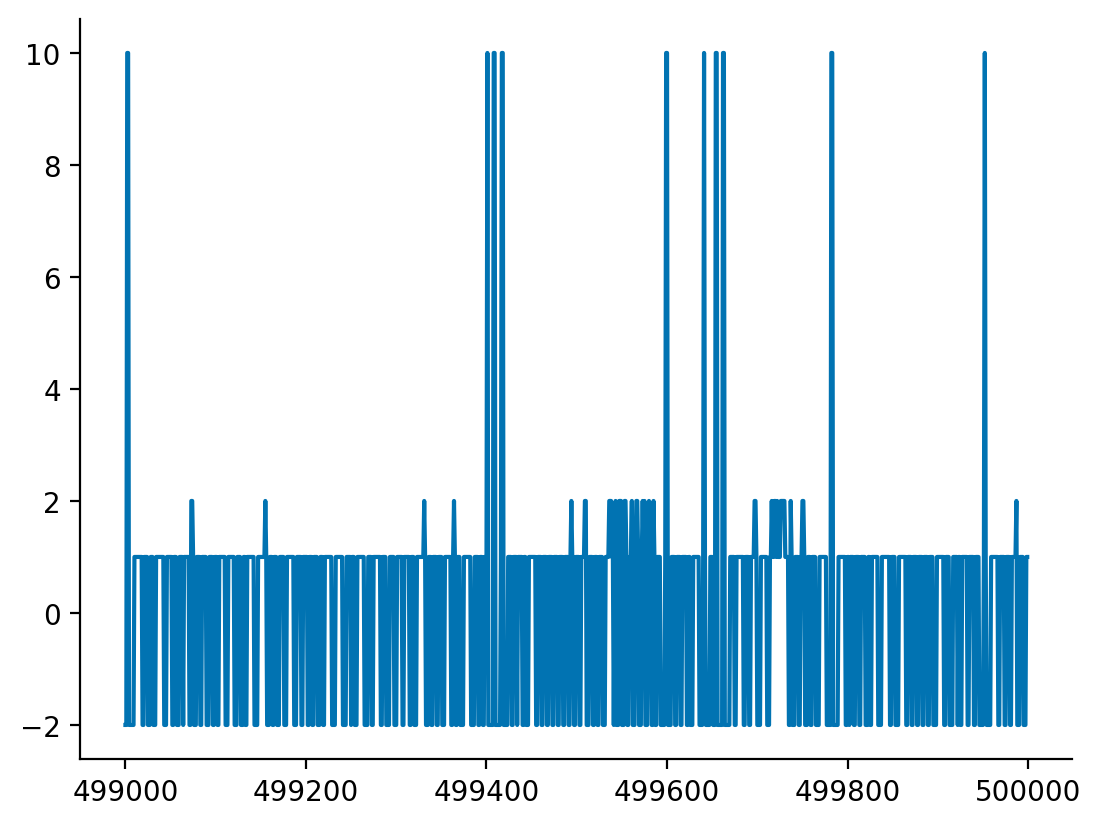

In [271]:
actions_hist[-1000:].plot()

<Axes: >

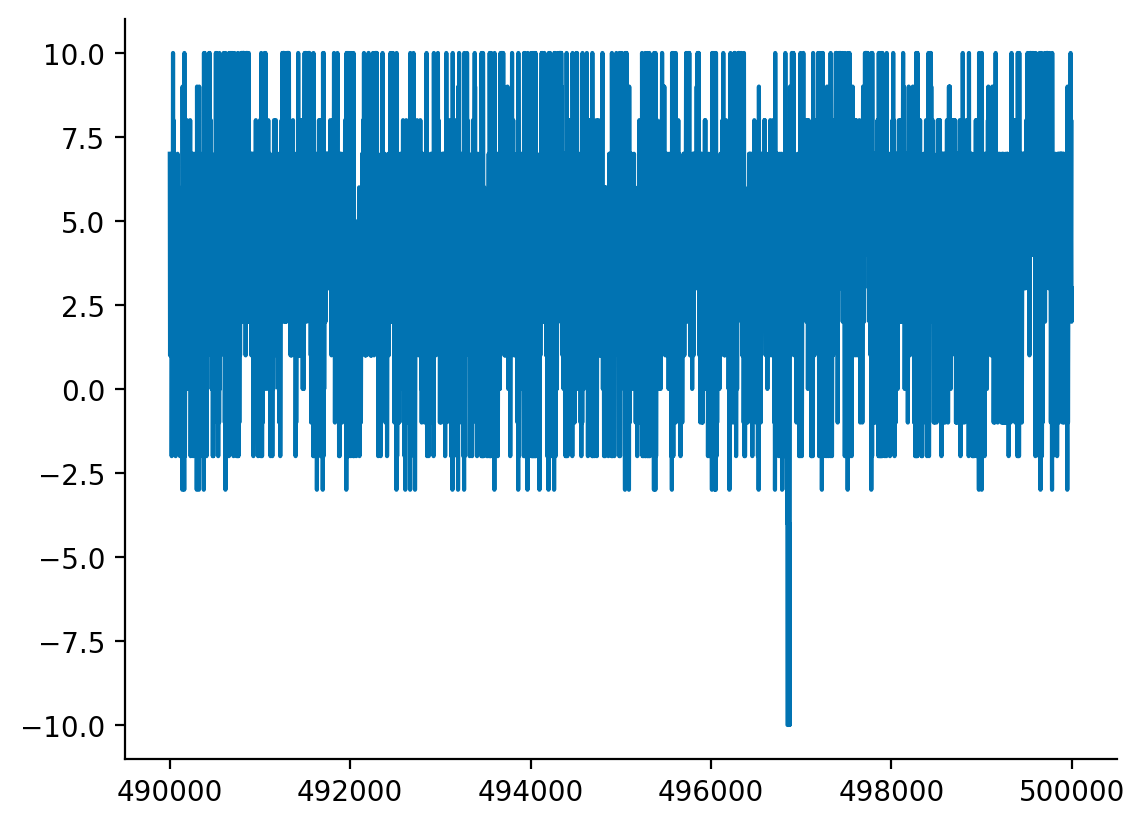

In [272]:
inventory_hist[-10_000:].plot()

In [273]:
weights

array([[-1.3452e-01,  6.8693e-02,  1.0308e+00,  6.5541e-02, -2.9677e-02],
       [ 4.9234e+00,  8.0008e+00,  6.9349e-01, -3.1439e+00, -5.8108e-01],
       [-9.3650e-01,  1.1135e+01, -1.5020e-01,  7.2773e+00,  3.5999e-01],
       [-1.7308e+00,  4.7968e+00,  6.7234e-01,  2.5583e+00, -4.2499e-01],
       [-7.4493e-01,  4.7185e-01,  2.9141e-01,  4.3449e-01,  9.8514e-03],
       [-9.6054e-03,  8.7034e-02,  7.7193e-01,  7.3917e-02, -7.1014e-02],
       [ 4.9399e-01,  6.7135e+00, -8.5962e-01,  5.8018e+00, -1.2030e+00],
       [ 1.9946e-01,  4.4905e+00,  1.1491e+00,  1.1524e+00,  2.6895e-01],
       [-1.5315e+00, -1.9436e+00,  3.4019e-01,  3.5354e+00,  7.9410e-02],
       [-1.2210e+00,  2.8759e+00,  1.5964e-01,  2.5534e+00, -2.8490e-01],
       [ 1.1489e-01,  5.3433e-02, -6.1859e-02,  3.9269e-02,  4.4348e-03],
       [-2.4952e+00, -3.9207e+00,  1.0242e-01,  5.0236e+00, -7.4972e-02],
       [-7.6602e-01, -9.1484e+00, -5.8943e-01,  1.4010e+01,  1.7117e-01],
       [-2.0100e+00,  1.2522e+00,  9.0

<Axes: >

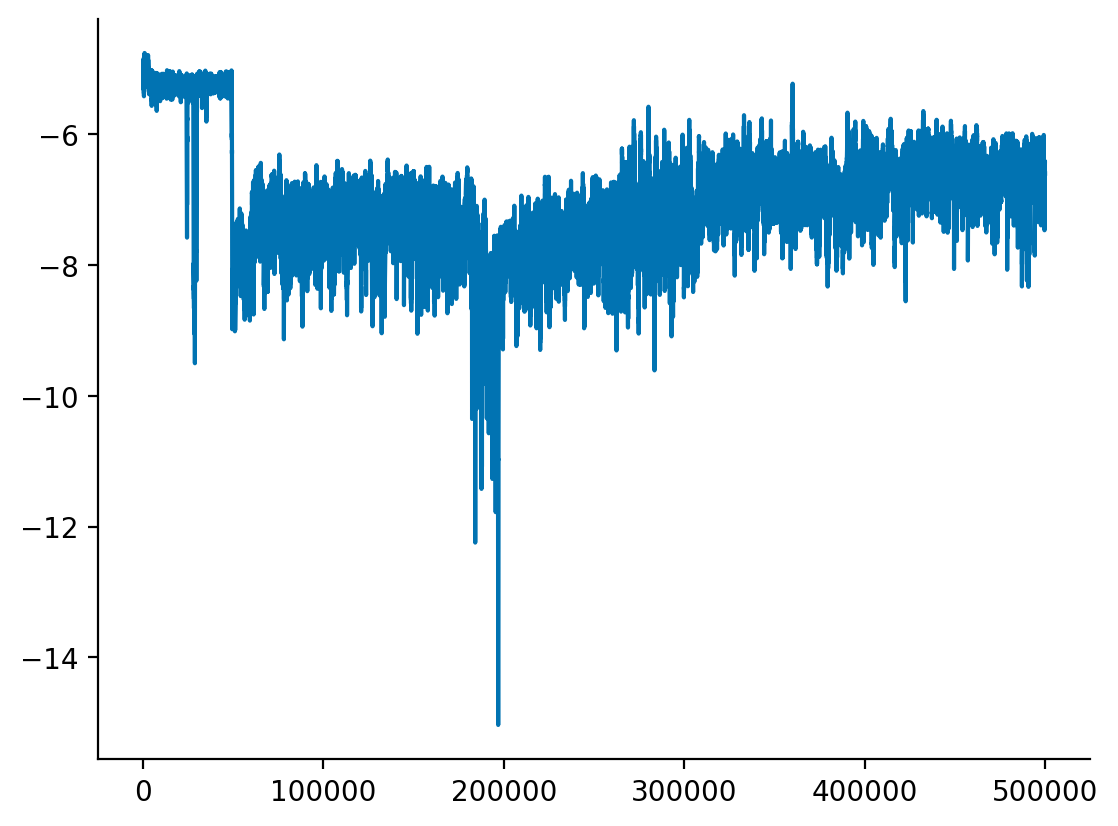

In [282]:
pd.Series(rewards).ewm(span=300, min_periods=100).mean().plot()

In [275]:
values_signals = bins_signal.copy()
values_inventory = np.arange(-MAX_INVENTORY, MAX_INVENTORY + 1)

In [276]:
values_inventory

array([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10])

In [277]:
values_signals

array([-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,  -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,
        -6.8,  -6.6,  -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,  -4.6,  -4.4,  -4.2,  -4. ,  -3.8,
        -3.6,  -3.4,  -3.2,  -3. ,  -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,  -1. ,  -0.8,  -0.6,
        -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,   0.8,   1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,   2.6,
         2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,   4.4,   4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,
         6. ,   6.2,   6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,   8. ,   8.2,   8.4,   8.6,   8.8,   9. ,
         9.2,   9.4,   9.6,   9.8,  10. ])

In [278]:
Z = np.zeros((len(values_signals), len(values_inventory)))
for i, vs in enumerate(values_signals):
    for j, vi in enumerate(values_inventory):
        s = np.array([vs, vi])
        # av = actions[action_value(weights, s, actions).argmax()]
        av = action_value(weights, s, actions).max()
        Z[i,j] = av

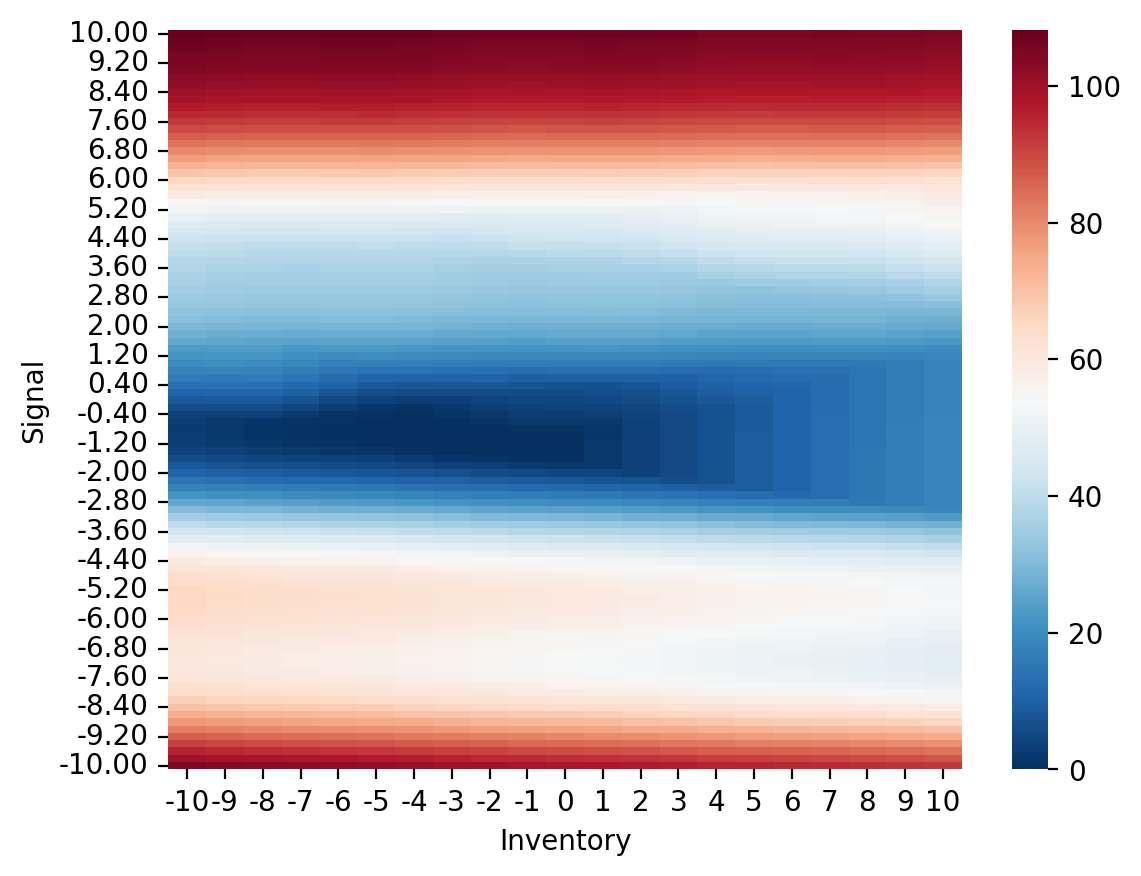

In [281]:
fig, ax = plt.subplots()
sns.heatmap(
    pd.DataFrame(Z, index=values_signals, columns=values_inventory),
    cmap="RdBu_r",
    ax=ax,
)
ax.set_yticklabels([format(float(v.get_text()), "0.2f") for v in ax.get_yticklabels()])
plt.gca().invert_yaxis()
plt.xlabel("Inventory")
plt.ylabel("Signal");